![bookstore](bookstore.jpg)


Identifying popular products is incredibly important for e-commerce companies! Popular products generate more revenue and, therefore, play a key role in stock control.

You've been asked to support an online bookstore by building a model to predict whether a book will be popular or not. They've supplied you with an extensive dataset containing information about all books they've sold, including:

* `price`
* `popularity` (target variable)
* `review/summary`
* `review/text`
* `review/helpfulness`
* `authors`
* `categories`

You'll need to build a model that predicts whether a book will be rated as popular or not.

They have high expectations of you, so have set a target of at least 70% accuracy! You are free to use as many features as you like, and will need to engineer new features to achieve this level of performance.

In [ ]:
# Import some required packages
import pandas as pd

# Read in the dataset
books = pd.read_csv("data/books.csv")

# Preview the first five rows
books.head()



,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [1]:
import pandas as pd
from transformers import pipeline

def get_text_score(df: pd.DataFrame, column_name: str, results_column_name: str) -> str:
    classifier = pipeline("sentiment-analysis", 
                        framework="pt", 
                        device=0,   
                        truncation=True,     # cut long texts to 512 tokens
                        padding=True         # pad shorter texts for batching
                        )
    text = df[column_name].tolist()
    results = classifier(text,batch_size=32)
    # Convert results back into DataFrame columns

    df[results_column_name] = [r["score"] for r in results]
    return df



/Users/sol/Code/datascience/good-books/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:

def preprocess_books(raw_df: pd.DataFrame) -> pd.DataFrame:
      df = raw_df.copy()
      df['total_reviews'] = df['review/helpfulness'].str.split('/').str[1].astype(int)
      df['helpful_reviews'] = df['review/helpfulness'].str.split('/').str[0].astype(int)
      df['percentage_helpful'] = df['helpful_reviews'] / df['total_reviews']
      df['percentage_helpful'] = df['percentage_helpful'].fillna(0)
      df = get_text_score(df, 'review/summary', 'review_summary_sentiment_score')
      df = get_text_score(df, 'review/text', 'review_text_sentiment_score')
      df = get_text_score(df, 'description', 'description_sentiment_score')
      df['popularity'] = df['popularity'].map(lambda x: 1 if x == "Popular" else 0)

      df.drop(columns=['title', 'review/helpfulness', 'categories', 'authors', 'review/summary', 'review/text', 'description'], inplace=True)

      return df

      

In [ ]:
books_processed.to_csv('data/books_processed.csv', index=False)

In [ ]:
#random forest
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import os


#read the processed books if it not exists process books
if not os.path.exists('§books_processed.csv'):
    books = pd.read_csv("data/books.csv")
    books_processed = preprocess_books(books)
else:
    books_processed = pd.read_csv('data/books_processed.csv')

y = books_processed['popularity']
X = books_processed.drop(columns=['popularity'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
#

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train_res, y_train_res)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


#Accuracy: 0.7585877862595419
#ROC-AUC: 0.8254456124106178



Accuracy: 0.7585877862595419
ROC-AUC: 0.8254456124106178


In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#metrics to check the model

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calculate and print additional metrics: F1-score and Recall
from sklearn.metrics import f1_score, recall_score

print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Accuracy: 0.7585877862595419
ROC-AUC: 0.8254456124106178
Confusion Matrix:
[[1678  420]
 [ 339  707]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2098
           1       0.63      0.68      0.65      1046

    accuracy                           0.76      3144
   macro avg       0.73      0.74      0.73      3144
weighted avg       0.76      0.76      0.76      3144

F1 Score: 0.650713299585826
Recall: 0.6759082217973231


In [47]:
#draw a confusion matrix with labels for each cell
import plotly.express as px

fig = px.imshow(confusion_matrix(y_test, y_pred),
          labels=dict(x="Predicted", y="Actual"),
          x=['Not Popular', 'Popular'],
          y=['Not Popular', 'Popular'],
          color_continuous_scale='Viridis',
          text_auto=True)

# Set title and center it
fig.update_layout(title="Confusion Matrix", title_x=0.5)
fig.show()


In [48]:
#add X validation
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print("Cross-validation scores (5-fold):", cv_scores)
print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
print("Std CV accuracy: {:.4f}".format(cv_scores.std()))


Cross-validation scores (5-fold): [0.74522901 0.74618321 0.74618321 0.7697201  0.79446389]
Mean CV accuracy: 0.7604
Std CV accuracy: 0.0194


In [ ]:
#save the model
import joblib

joblib.dump(rf_model, 'models/rf_model_smote_stratified.joblib')

#load the model
rf_model = joblib.load('models/rf_model_smote_stratified.joblib')

#make a prediction
prediction = rf_model.predict(X_test)

#print the prediction
print(prediction)


[1 1 0 ... 1 1 0]


In [19]:
books_processed['popularity'].value_counts()

0    10490
1     5229
Name: popularity, dtype: int64

## Class imbalance 

Majority class (0) proportion ≈ 66.7%

Minority class (1) proportion ≈ 33.3%

### Find Threshold

In [51]:
import numpy as np
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Skip the first element because thresholds has len = len(f1_scores)-1
best_idx = np.argmax(f1_scores[1:])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx + 1]

print("Best threshold:", best_threshold)
print("Best F1 score:", best_f1)

# Apply best threshold
y_pred_thresh = (y_prob >= best_threshold).astype(int)

print("\nConfusion Matrix with best threshold:\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report with best threshold:\n", classification_report(y_test, y_pred_thresh))



Best threshold: 0.33
Best F1 score: 0.6792027077848815

Confusion Matrix with best threshold:
 [[1365  733]
 [ 135  911]]

Classification Report with best threshold:
               precision    recall  f1-score   support

           0       0.91      0.65      0.76      2098
           1       0.55      0.87      0.68      1046

    accuracy                           0.72      3144
   macro avg       0.73      0.76      0.72      3144
weighted avg       0.79      0.72      0.73      3144



# apply threshold

In [52]:
y_pred_thresh = (y_probs >= best_threshold).astype(int)


### evaluate

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))


Confusion Matrix:
 [[1349  749]
 [ 682  364]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      2098
           1       0.33      0.35      0.34      1046

    accuracy                           0.54      3144
   macro avg       0.50      0.50      0.50      3144
weighted avg       0.55      0.54      0.55      3144



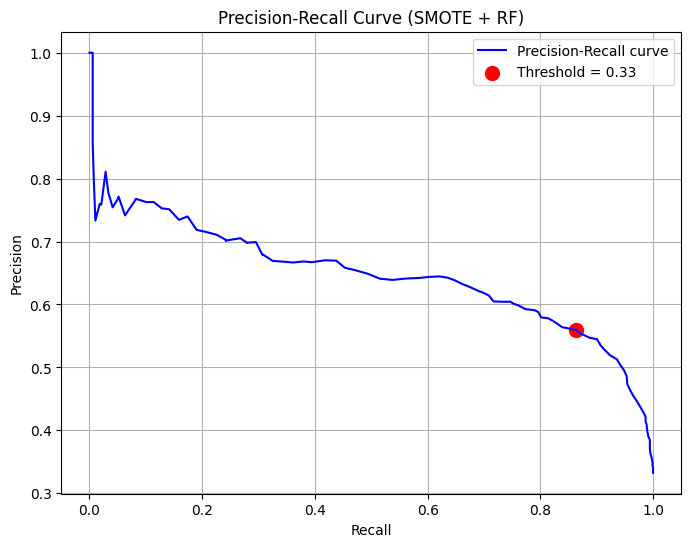

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# y_test = your test labels
# y_prob = predicted probabilities for class 1 from your SMOTE-trained RF

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Precision-Recall curve', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SMOTE + RF)')
plt.grid(True)

# Mark the best threshold
best_threshold = 0.33
# thresholds array is shorter than precision/recall, so shift by +1
best_idx = np.abs(thresholds - best_threshold).argmin()
plt.scatter(recall[best_idx+1], precision[best_idx+1], color='red', s=100, label=f'Threshold = {best_threshold}')
plt.legend()
plt.show()
